# Learning a Predictor for Maximum Daytime Temperature 
# with Polynomial Regression

In [72]:
# import necessary libraries
import pandas as pd  # for data input/output and processing
import numpy as np  # for matrix calculations

from sklearn.linear_model import LinearRegression  # An already implemented version of linear regression
from sklearn.preprocessing import PolynomialFeatures  # To transform our features to the corresponding polynomial version
from sklearn.metrics import mean_squared_error  # a way to evaluate how erroneous our model is

import matplotlib.pyplot as plt  # For visualizations

In [73]:
plt.rcParams.update({'font.size': 20})

## The Data 

We consider datapoints that represent individual days. Each datapoint is characterized by the maximum daytime temperature as label $y$. Our goal is to learn a hypothesis $h$ that delivers an accurate prediction $\hat{y} = h(x)$ for the label $y$. The hypothesis is applied to some feature $x$ of the datapoint (day). We will consider different choices for the feature below. 

Polynomial regression learns a hypothesis that is a polynomial wight maximum degree $r$, 
$$h(x) = w_{1} + w_{2} x + w_{3} x^{2} + \ldots + w_{r+1} x^{r}.$$ 
The coefficients (or parameters) $w_{1},\ldots,w_{r+1}$ are learnt by minimizing the average squared error 
$$(1/m) \sum_{i=1}^{m} \big( y^{(i)} - h\big( x^{(i)} \big) \big)^2,$$
incurred for a training set $\big(x^{(1)},y^{(1)}\big),\ldots,\big(x^{(m)},y^{(m)}\big)$. 

We construct the training set $\big(x^{(1)},y^{(1)}\big),\ldots,\big(x^{(m)},y^{(m)}\big)$ using weather recordings from the Finnish meteorological institute (FMI). These weather recordings are stored in the file "FMIData.csv". The code snippet below reads in the weather recordings from the file "FMIData.csv" and stores them in the `pandas dataframe` with name `df`. 

In [74]:
# First load the dataset into a pandas DataFrame
df = pd.read_csv("FMIData.csv")
print("number m of data points =", len(df))
df.head(2)  # print the first 2 rows

number m of data points = 60


,Year,m,d,Time,Time zone,Maximum temperature (degC),Minimum temperature (degC)
0,2020,2,1,00:00,UTC,3.0,1.9
1,2020,2,2,00:00,UTC,4.9,2.4


Each row in the above dataframe corresponds to a specific datapoint (day). The value in the column "Maximum temperature" is used as the label $y$ of the datapoint. All other columns can be potentially used as the feature $x$ of the datapoint. 

Let use consider two different choices for the feature of a datapoint. The first choice for the feature $x$ is the value in the column `day`. The second choice for the feature $x$ is the value in the column "Minimum temperature". The following code snippet selects only those columns of the dataframe. 

In [75]:
feature_columns = ["d", "Minimum temperature (degC)"]
label_column = ["Maximum temperature (degC)"]
# Keep only relevant columns
df = df[feature_columns+label_column]
df.head(2)

,d,Minimum temperature (degC),Maximum temperature (degC)
0,1,1.9,3.0
1,2,2.4,4.9


In [76]:
df.columns = ['d', 'min_temp', 'max_temp']
df.head(2)

,d,min_temp,max_temp
0,1,1.9,3.0
1,2,2.4,4.9


In [77]:
# First step: Drop NaN (Not A Number) values
df.dropna(inplace=True)
len(df)

60

To explore the relationship between different features and the label of datapoints it is often helpful to generate a scatterplot. The code snippet below generates two scatterplots. 

- The left scatterplot depicts the datapoints in `df` as dots in a plane with horizontal axis representing the values of the column `day` (which is one potential feature of the datapoint) and the vertical axis representing the values of the column "Maximum temperature" (which is the label of the datapoint). 

- The right scatterplot depicts the datapoints in `df` as dots in a plane with horizontal axis representing the values of the column `Minimum temperature` (which is one potential feature of the datapoint) and the vertical axis representing the values of the column "Maximum temperature" (which is the label of the datapoint).  

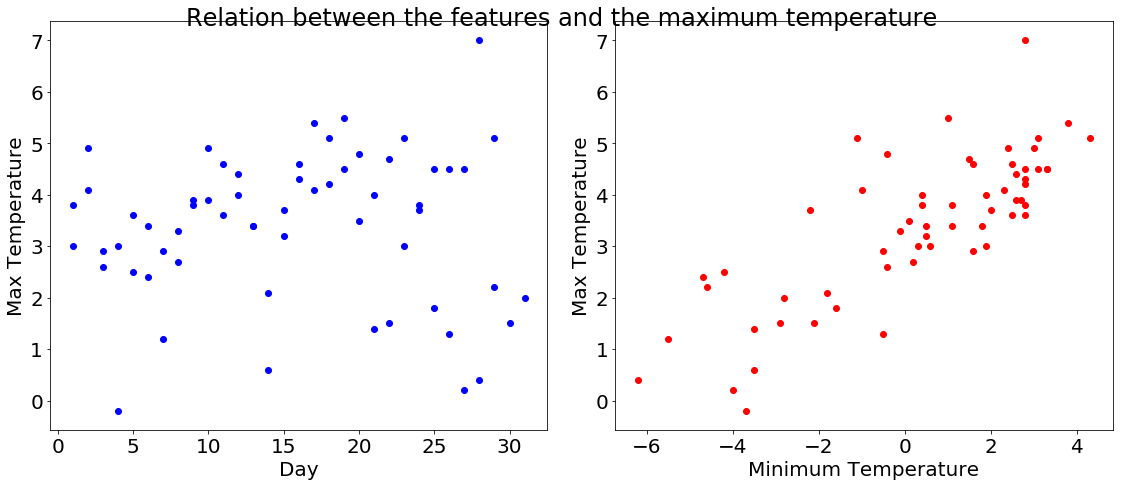

In [78]:
# def plot_model(X, y, 
fig=plt.figure(figsize=(16, 7))
fig.suptitle("Relation between the features and the maximum temperature")
plt.subplot(1, 2, 1)
plt.scatter(df.d, df.max_temp, c="blue")
plt.xlabel("Day")
plt.ylabel("Max Temperature")
plt.subplot(1, 2, 2)
plt.scatter(df.min_temp, df.max_temp, c="red")
plt.xlabel("Minimum Temperature")
plt.ylabel("Max Temperature")
fig.tight_layout()  # Separate the two subplots
plt.show()

The `d` (day) column seems to have a very noisy relationship with the target. On the other hand, the `min_temp` column seems to have a clearly linear relationship with the target and so we consider it important/informative.

For this reason we are going to completely ignore the `d` column and move on with the `min_temp` as our only feature. Using 1 feature also allows for better visualizations in a 2d space (e.g. if we had two features, then we would need 3 axes in total, and 3d plots are not as intuitive as 2d plots. If we had 3 features, then visualization would be impossible).

In [79]:
df.drop(columns=['d'], inplace=True)
df.head(2)

,min_temp,max_temp
0,1.9,3.0
1,2.4,4.9


In [80]:
# Let's separate features from labels
labels = df.max_temp.values  # .values convert to a numpy array
features = df.drop(columns=['max_temp']).values

## Linear Regression is Polynomial Regression with Degree 1 

### Loss Function

Linear regression tries to minimize the Mean Squared Error (MSE) loss function, to get the best possible predictor function $h$. MSE is given by: 
$$MSE = \frac{1}{m} \sum_{i=1}^m (y^{(i)} - h(x^{(i)}))^2$$

where $h(x^{(i)})$ is the predicted label for the $i$-th datapoint. In turn, $x$ is a vector of the features that we want to use in order to get a prediction as close to the ground truth $y^{(i)}$ as possible.

### Hypothesis Space
For degree $r=1$, polynomial regression reduces to linear regression. Linear regression learns a linear hypothesis 
$$
h(x) = w_1 +  w_2 x. 
$$
We learn the parameters $w_{1}, w_{2}$ by minimizing the average squared error or MSE. The code snippet below uses the `scikit-learn` class `LinearRegression()` to implement linear regression. 

In [81]:
# Create a linear regression model
lr = LinearRegression()
# Fit the model to our data in order to get the most suitable parameters
lr = lr.fit(features, labels)

In [82]:
# Calculate the mean square error on the training set
predictions = lr.predict(features)
mean_squared_error(predictions, labels)  # ideally this would be 0 which would mean that the predictions are very close to the ground truth

0.7610354562839377

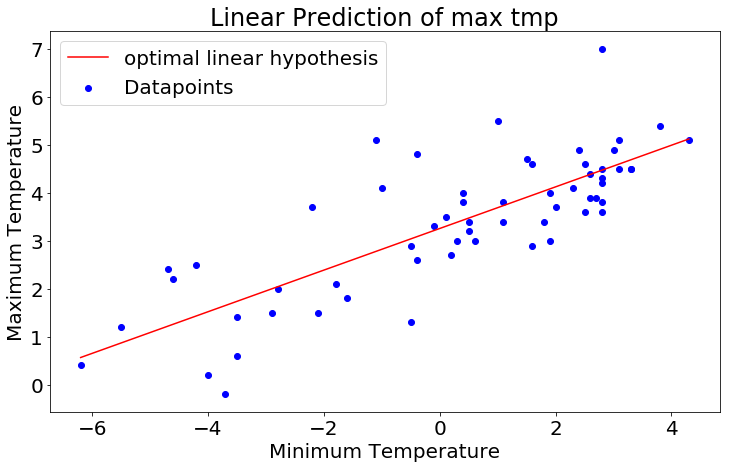

In [83]:
plt.figure(figsize=(12,7))
# How good does the model fit our data?
plt.scatter(features, labels, c="blue", label="Datapoints")
# an increasing vector in the [min, max] range of the features
X_line = np.linspace(features.min(), features.max(), len(features)).reshape(-1, 1)  # needs to be 2d and so we reshape
predictions = lr.predict(X_line)
plt.plot(X_line, predictions, c="red", label="optimal linear hypothesis")
plt.xlabel("Minimum Temperature")
plt.ylabel("Maximum Temperature")
plt.title("Linear Prediction of max tmp")
plt.legend()
plt.show()

## Polynomial Regression

The above predictor function is good for relations $x \rightarrow y$ that exhibit a strictly linear relation. In the figure bellow though, we can see that the relation is not always linear:

![](./non-linear-relation.png)

In such cases, we can increase the degree of the linear function and also include terms raised to some power $r$, for $r>1$.

Getting back to our example, we could now transform the predictor function to:
$$
\hat{h}(x) = w_0 + w_1 x + w_1 x^2 + ... + w_{r+1} x^r
$$

To find the best value of $r$ we usually have to search through a lot of values, as follows:

In [84]:
def get_poly_predictor(features, labels, degree):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    # transform features so as to include their polynomial version.
    # E.g. feas_new will now also include x^2, ..., x^{degree}
    feas_new = poly_features.fit_transform(features)
    lr = LinearRegression()
    lr.fit(feas_new, labels)
    mse = mean_squared_error(lr.predict(feas_new), labels)
    return mse

In [85]:
# Try out different degrees and print the corresponding MSEs
for r in range(2, 18, 2):
    mse = get_poly_predictor(features, labels, degree=r)
    print(f"Degree={r} -> training error={mse}")

Degree=2 -> training error=0.7609297067884181
Degree=4 -> training error=0.7528852230641694
Degree=6 -> training error=0.6933588875501544
Degree=8 -> training error=0.6861387622564956
Degree=10 -> training error=0.6283257414847673
Degree=12 -> training error=0.6277316086004313
Degree=14 -> training error=0.5748724705215218
Degree=16 -> training error=0.5499997334536294


The training errors decrease with increasing polyonmial degree. Does that mean that we should use very large degreees for polynomial regression? Let us inspect the learnt polynomials for a few specific choices for the polynomial degree. 

In [86]:
def poly_visualize(
        features, 
        labels, 
        degrees=[2, 4, 8, 18], 
        colors=['blue', 'green', 'cyan', 'purple'],
        n_wrong_models=0,
    ):
    fig = plt.figure(figsize=(20, 15))
    wrong_poly_colors = ['gold', 'teal', 'tomato', 'firebrick', 'orchid']
    for i, r in enumerate(degrees):
        # ===================================================================
        # Fit model
        # ===================================================================
        poly_features = PolynomialFeatures(degree=r, include_bias=False)
        feas_new = poly_features.fit_transform(features)
        lr = LinearRegression()
        lr.fit(feas_new, labels)
        # ===================================================================
        # Fit some models on wrong data to see how the polynomial changes
        # ===================================================================
        polys_perturbed = []
        for j in range(n_wrong_models):
            feas_perturbed = np.random.permutation(feas_new)
            polys_perturbed.append(LinearRegression().fit(feas_perturbed, labels))
        # ===================================================================
        # Scatter plot
        # ===================================================================
        plt.subplot(2, 2, i+1)
        # How good does the model fit our data?
        plt.scatter(features, labels, c="blue", label="Datapoints")
        # an increasing vector in the [min, max] range of the features
        X_line = np.linspace(features.min(), features.max(), 200).reshape(-1, 1)  # needs to be 2d and so we reshape
        predictions = lr.predict(poly_features.transform(X_line))
        plt.plot(X_line, predictions, c="red", label="Learnt Hypothesis", linewidth=7.0)
        for j in range(n_wrong_models):
            preds_perturbed = polys_perturbed[j].predict(poly_features.transform(X_line))
            color = wrong_poly_colors[j%len(wrong_poly_colors)]
            plt.plot(X_line, preds_perturbed, c=color, label=f"Hypothesis {j+2}")
        plt.xlabel("Minimum Temperature")
        plt.ylabel("Maximum Temperature")
        mse = mean_squared_error(lr.predict(feas_new), labels)
        plt.title(f"Degree {r} - MSE={round(mse, 2)}")
        plt.legend()
    plt.show()

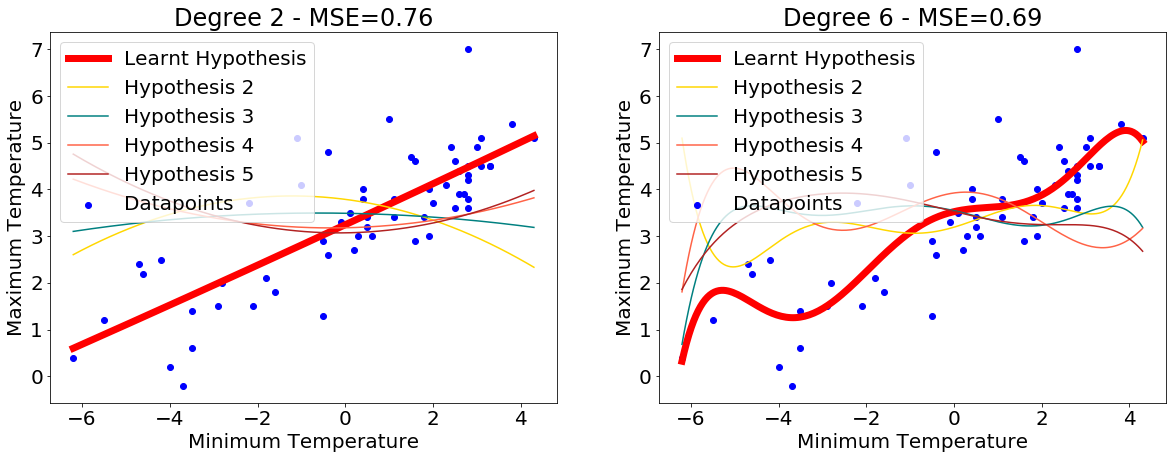

In [87]:
poly_visualize(features, labels, degrees=[2, 6], colors=["blue", "green"], n_wrong_models=4)

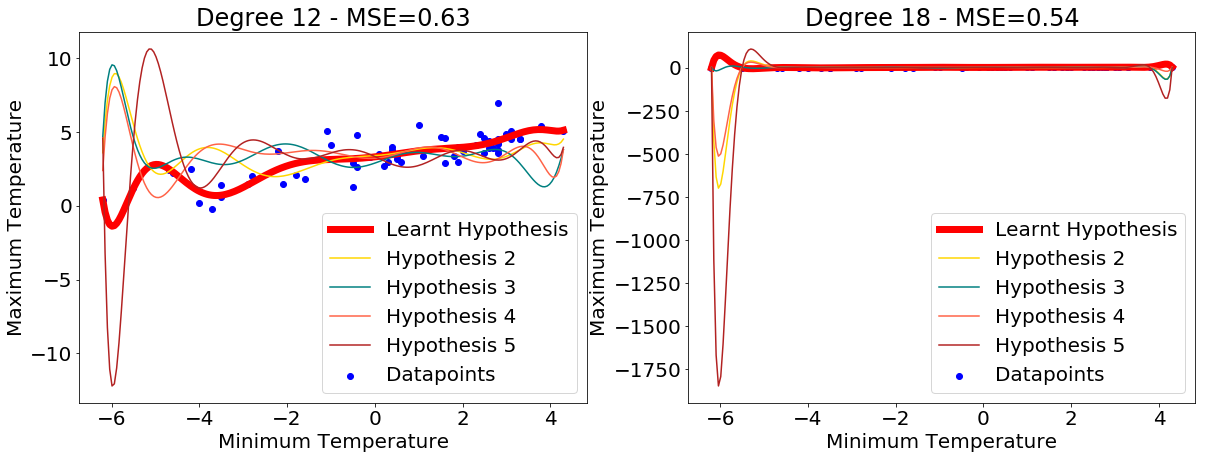

In [88]:
poly_visualize(features, labels, degrees=[12, 18], colors=["cyan", "purple"], n_wrong_models=4)

### Overfitting

As we can see form the above plots, using larger polynomial degrees results in a learnt hypothesis that fits the training data (in the dataframe `df`) quite well (polynomial regression tries to find a curve that passes through each and every datapoint of the training set).

However for increasing degrees the learnt hypothesis becomes less reasonable. In particular, the hypothesis learnt for degrees larger than one are not monotonically increasing. This is counter-intuitive as a higher minimum daytime temperature should imple a higher maximum daytime temperature. More generally, while the learnt high degree polynomials fit well the datapoints in the training set they seem to deliver poor predictions for feature values that are not covered in the training set. 